## Identifying Duplicate Questions

Over 100 million people visit *Quora* every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. *Quora* uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.

Follow the steps outlined below to build the appropriate classifier model. 

Steps:
- Download or load the data
- Exploration (EDA)
- Cleaning
- Feature Engineering
- Modeling

By the end of this project you should have **a presentation that describes the model you built** and its **performance**. 

### Step 1: Loading the data

In [86]:
# Import basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [87]:
# Load "Quora" dataset
df = pd.read_csv("/Users/rafaelaqueiroz/Mini-Project-V/train.csv")
df.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


### Note
There is no designated test.csv file. The train.csv file is the entire dataset. Part of the data in the train.csv file should be set aside to act as the final testing data.

#### Let's first split the dataset

In [155]:
# Split the data into X and y variables
X = df[['question1', 'question2']]
y = df['is_duplicate']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1000)

In [ ]:
X_train.shape

### Step 2: Exploration

In [88]:
# Check the number of rows and columns of the dataset
df.shape

(404290, 6)

The dataset has 6 columns and 404,290 rows in total.

In [89]:
# Check for missing or NaN values
df.isnull() # It returns a boolean df indicating the presence or absence of missing values in each cell of it

,id,qid1,qid2,question1,question2,is_duplicate
0,False,False,False,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,False,False
3,False,False,False,False,False,False
4,False,False,False,False,False,False
...,...,...,...,...,...,...
404285,False,False,False,False,False,False
404286,False,False,False,False,False,False
404287,False,False,False,False,False,False
404288,False,False,False,False,False,False


In [90]:
# Check for the total missing or NaN values
df.isnull().sum() # It sums up the number of 'True' values for each column

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [91]:
# Investigate the 3 rows that have the missing values
df[df.isnull().any(axis=1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


Even though the first 2 rows have questions that are not marked as duplicates, they are semantically similar and produce the same pragmatic meaning. This is an important point to consider when building a model to identify duplicate questions, as it highlights the need to use NLP techniques that can capture the semantic similarity between questions, beyond just comparing the text directly.

Also, as we only have 3 NaN values, we decided to drop them as this represents a small percentage of duplicates in comparison with our total data. However, if this would represent a bigger percentage, the act of dropping rows would be needed to consider with caution as this could introduce bias to our dataset and affect the overall performance of our model. 

In [92]:
# Drop the missing values from the dataset
df.dropna(subset=['question1', 'question2'], inplace=True)

In [93]:
# Check for duplicate values before moving forward to our cleaning and preprocessing data
df_counts = df['is_duplicate'].value_counts() # It counts de number of duplicate and non-duplicate questions in the dataset
df_counts

0    255024
1    149263
Name: is_duplicate, dtype: int64

In [94]:
# Check the duplicate counts in terms of each percentage ("question1" and "question2") from the total
percentages = df_counts / len(df) * 100
percentages

0    63.079941
1    36.920059
Name: is_duplicate, dtype: float64

Now, let's visualize the percentage of each data to see its proportionality in 2 different graphs as this will help us to understand the impact of the amount of duplicates of "question 1" in comparison with "question 2", considering the total number of the questions.

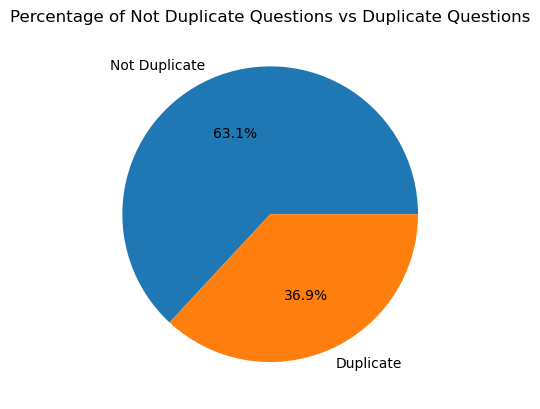

In [95]:
# Plot as a pie chart
labels = ['Not Duplicate', 'Duplicate']
plt.pie(percentages, labels=labels, autopct='%1.1f%%') 
plt.title('Percentage of Not Duplicate Questions vs Duplicate Questions')
plt.show()

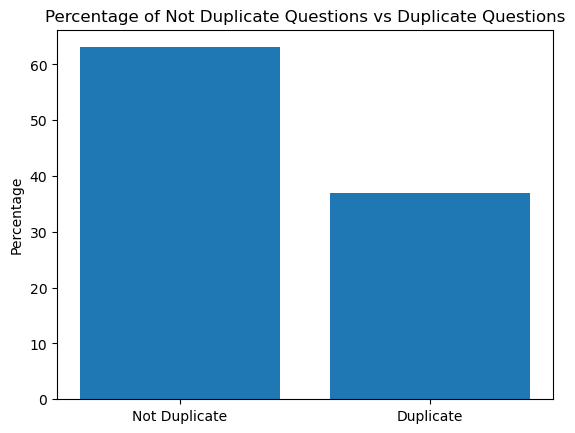

In [96]:
# Plot as a bar chart
plt.bar(labels, percentages)
plt.title('Percentage of Not Duplicate Questions vs Duplicate Questions')
plt.ylabel('Percentage')
plt.show()

There are 255,024 non-duplicate questions and 149,263 duplicate questions in the dataframe. This is an important factor to be considered before making our model as the count of non-duplicate and duplicate questions can help us to understand the nature of the dataset and, likewise, to give us some information on how to approach a model to identify duplicate questions.

In our case, the number of duplicate questions (given by the Boolean 1) is much smaller than the number of non-duplicate questions. Then this could indicate that the dataset is imbalanced, which may affect the performance of the model afterwards. Thus, we might need to employ techniques like undersampling or oversampling to balance the dataset.

As this can pose a challenge when building a model - the model may be biased towards classifying questions as non-duplicates, leading to a poor performance on identifying duplicates -, we decided to address this balance with the use of undersampling.

In [97]:
# Select randomly a subset of non-duplicate questions to match the number of duplicate questions
duplicates = df[df['is_duplicate'] == 1] # Separate the duplicate and non-duplicate questions
non_duplicates = df[df['is_duplicate'] == 0]
num_duplicates = len(duplicates) # Get the number of duplicate questions
non_duplicates_sampled = non_duplicates.sample(num_duplicates) # Select a subset of non-duplicate questions

# Combine the sampled non-duplicate questions with the original duplicate questions
balanced_df = pd.concat([duplicates, non_duplicates_sampled], axis=0) 

# Shuffle the dataset to ensure that the duplicate and non-duplicate questions are mixed
balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)
balanced_df

,id,qid1,qid2,question1,question2,is_duplicate
0,27202,50552,50553,Can hamsters eat cucumber?,Can hamsters eat peanuts? Are they harmful for...,1
1,133852,214057,214058,Did Native American tribes invade and conquer ...,How do you join a Native American tribe?,0
2,224670,85558,275719,How do I download a video from any website?,How can I download videos from several websites?,1
3,340145,81907,44487,What are the creepiest paranormal experiences ...,Has someone ever experienced paranormal activity?,1
4,94646,29186,158003,How does linkis.com make money?,How does iimjobs.com make money?,0
...,...,...,...,...,...,...
298521,48935,87151,87152,What are some recipes for a Marsala Alfredo sa...,What is the best way to burn parchment paper?,0
298522,212772,6419,151321,Who is/was the most underrated actor/actress i...,Who is Bollywood's most underrated actor?,1
298523,173768,267986,267987,Dreams and Dreaming: What is your idea of Utopia?,Do you have any idea about lucid dreaming?,0
298524,345957,266785,34901,What is best source for start learning digital...,What should I learn to become a best digital m...,1


In [98]:
# Now, let's check if our dataset is more balanced
balanced_df['is_duplicate'].value_counts()

1    149263
0    149263
Name: is_duplicate, dtype: int64

### Step 3: Cleaning

- Removing punctuation
- Tokenization
- Cleaning stopwords
- Normalizing
- Stemming or Lemmitization

In order to clean (more) and preprocess the text data, we are going to apply different techniques, such as, converting it to lowercase, removing stop words and punctuation, and stemming or lemmatization of the the words.

#### Removing punctuation

In [99]:
# Import more libraries
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [100]:
# Define a function to remove punctuation in our "question1" and "question2" columns
def remove_punct(text):
    text = "".join([char for char in text if char not in string.punctuation])
    return text

balanced_df = balanced_df.assign( # Assigning the new 2 columns in the dataframe
    question1_cleaned=balanced_df["question1"].apply(remove_punct),
    question2_cleaned=balanced_df["question2"].apply(remove_punct)
)

balanced_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,question1_cleaned,question2_cleaned
0,27202,50552,50553,Can hamsters eat cucumber?,Can hamsters eat peanuts? Are they harmful for...,1,Can hamsters eat cucumber,Can hamsters eat peanuts Are they harmful for ...
1,133852,214057,214058,Did Native American tribes invade and conquer ...,How do you join a Native American tribe?,0,Did Native American tribes invade and conquer ...,How do you join a Native American tribe
2,224670,85558,275719,How do I download a video from any website?,How can I download videos from several websites?,1,How do I download a video from any website,How can I download videos from several websites
3,340145,81907,44487,What are the creepiest paranormal experiences ...,Has someone ever experienced paranormal activity?,1,What are the creepiest paranormal experiences ...,Has someone ever experienced paranormal activity
4,94646,29186,158003,How does linkis.com make money?,How does iimjobs.com make money?,0,How does linkiscom make money,How does iimjobscom make money


In [101]:
# Drop the columns that are not going to be used anymore
balanced_df = balanced_df.drop(['id', 'qid1', 'qid2', 'question1', 'question2'], axis=1)
balanced_df.tail()

,is_duplicate,question1_cleaned,question2_cleaned
298521,0,What are some recipes for a Marsala Alfredo sauce,What is the best way to burn parchment paper
298522,1,Who iswas the most underrated actoractress in ...,Who is Bollywoods most underrated actor
298523,0,Dreams and Dreaming What is your idea of Utopia,Do you have any idea about lucid dreaming
298524,1,What is best source for start learning digital...,What should I learn to become a best digital m...
298525,0,I want a gaming console which survives longer ...,Do Americans like British people How are they ...


#### Tokenization and applying lower case

In [102]:
# Import regular expression library
import re

In [103]:
# Define a function to split our sentences into a list of words
def tokenize(text):
    tokens = text.split()
    return tokens

balanced_df['question_1_tokenized'] = balanced_df['question1_cleaned'].apply(lambda x: tokenize(x.lower()))
balanced_df['question_2_tokenized'] = balanced_df['question2_cleaned'].apply(lambda x: tokenize(x.lower()))
balanced_df.tail(2)

,is_duplicate,question1_cleaned,question2_cleaned,question_1_tokenized,question_2_tokenized
298524,1,What is best source for start learning digital...,What should I learn to become a best digital m...,"[what, is, best, source, for, start, learning,...","[what, should, i, learn, to, become, a, best, ..."
298525,0,I want a gaming console which survives longer ...,Do Americans like British people How are they ...,"[i, want, a, gaming, console, which, survives,...","[do, americans, like, british, people, how, ar..."


In [104]:
# Drop the previous columns
balanced_df = balanced_df.drop(['question1_cleaned', 'question2_cleaned'], axis=1)
balanced_df.tail(2)

,is_duplicate,question_1_tokenized,question_2_tokenized
298524,1,"[what, is, best, source, for, start, learning,...","[what, should, i, learn, to, become, a, best, ..."
298525,0,"[i, want, a, gaming, console, which, survives,...","[do, americans, like, british, people, how, ar..."


#### Removing the stopwords

In [105]:
# Import the NLTK package
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# View the stopwords
ENGstopwords = stopwords.words('english')
ENGstopwords[0:25]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rafaelaqueiroz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers']

In [106]:
# Define a function to remove all stopwords
def remove_stopwords(tokenized_text):    
    text = [word for word in tokenized_text if word not in ENGstopwords]
    return text

balanced_df['question1_non_stop'] = balanced_df['question_1_tokenized'].apply(lambda x: remove_stopwords(x))
balanced_df['question2_non_stop'] = balanced_df['question_2_tokenized'].apply(lambda x: remove_stopwords(x))
balanced_df.tail(2)

,is_duplicate,question_1_tokenized,question_2_tokenized,question1_non_stop,question2_non_stop
298524,1,"[what, is, best, source, for, start, learning,...","[what, should, i, learn, to, become, a, best, ...","[best, source, start, learning, digital, marke...","[learn, become, best, digital, marketer]"
298525,0,"[i, want, a, gaming, console, which, survives,...","[do, americans, like, british, people, how, ar...","[want, gaming, console, survives, longer, dies...","[americans, like, british, people, viewed, us]"


In [107]:
# Drop the previous columns
balanced_df = balanced_df.drop(['question_1_tokenized', 'question_2_tokenized'], axis=1)
balanced_df.tail(2)

,is_duplicate,question1_non_stop,question2_non_stop
298524,1,"[best, source, start, learning, digital, marke...","[learn, become, best, digital, marketer]"
298525,0,"[want, gaming, console, survives, longer, dies...","[americans, like, british, people, viewed, us]"


#### Stemming

In [108]:
# Import modules 
nltk.download('punkt')
from nltk.stem import PorterStemmer

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rafaelaqueiroz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [109]:
# Create a stemmer object
ps = PorterStemmer() # It will remove pre-defined stems

# Define a function to stem the text
def stemmed_text(words):
    stemmed_words = []
    for word in words:
        stemmed_words.append(ps.stem(word))
    return stemmed_words

In [110]:
# Call up the function that applies stemmed_text to our columns in the data frame
balanced_df['question1_stem'] = balanced_df['question1_non_stop'].apply(lambda x: stemmed_text(x))
balanced_df['question2_stem'] = balanced_df['question2_non_stop'].apply(lambda x: stemmed_text(x))
balanced_df.tail(2)

,is_duplicate,question1_non_stop,question2_non_stop,question1_stem,question2_stem
298524,1,"[best, source, start, learning, digital, marke...","[learn, become, best, digital, marketer]","[best, sourc, start, learn, digit, market]","[learn, becom, best, digit, market]"
298525,0,"[want, gaming, console, survives, longer, dies...","[americans, like, british, people, viewed, us]","[want, game, consol, surviv, longer, die, last...","[american, like, british, peopl, view, us]"


Before dropping the previous columns, we are going to make a comparative of the modification results with the lemmitization technique.

#### Lemmatization

In [111]:
# Importing some modules 
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rafaelaqueiroz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/rafaelaqueiroz/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [112]:
# Create a lemmatizer object
lemmatizer = WordNetLemmatizer() 

# Create a function to apply lemmitization into our words
def lemmitization(words):
    lemmitization_words = []
    for word in words:
        lemmitization_list = ' '.join([lemmatizer.lemmatize(word) for word in words])
        lemmitization_words.append(lemmitization_list)
    return lemmitization_words 

In [113]:
# Call up the function that applies lemmitization to our columns in the data frame
balanced_df['question1_lemm'] = balanced_df['question1_non_stop'].apply(lambda x: stemmed_text(x))
balanced_df['question2_lemm'] = balanced_df['question2_non_stop'].apply(lambda x: stemmed_text(x))
balanced_df.tail(5)

,is_duplicate,question1_non_stop,question2_non_stop,question1_stem,question2_stem,question1_lemm,question2_lemm
298521,0,"[recipes, marsala, alfredo, sauce]","[best, way, burn, parchment, paper]","[recip, marsala, alfredo, sauc]","[best, way, burn, parchment, paper]","[recip, marsala, alfredo, sauc]","[best, way, burn, parchment, paper]"
298522,1,"[iswas, underrated, actoractress, bollywood]","[bollywoods, underrated, actor]","[iswa, underr, actoractress, bollywood]","[bollywood, underr, actor]","[iswa, underr, actoractress, bollywood]","[bollywood, underr, actor]"
298523,0,"[dreams, dreaming, idea, utopia]","[idea, lucid, dreaming]","[dream, dream, idea, utopia]","[idea, lucid, dream]","[dream, dream, idea, utopia]","[idea, lucid, dream]"
298524,1,"[best, source, start, learning, digital, marke...","[learn, become, best, digital, marketer]","[best, sourc, start, learn, digit, market]","[learn, becom, best, digit, market]","[best, sourc, start, learn, digit, market]","[learn, becom, best, digit, market]"
298525,0,"[want, gaming, console, survives, longer, dies...","[americans, like, british, people, viewed, us]","[want, game, consol, surviv, longer, die, last...","[american, like, british, peopl, view, us]","[want, game, consol, surviv, longer, die, last...","[american, like, british, peopl, view, us]"


In [114]:
# Drop previous columns and staying with the lemmatization technique
balanced_df = balanced_df.drop(['question1_non_stop', 'question2_non_stop', 'question1_stem', 'question2_stem'], axis=1)
balanced_df.tail(2)

,is_duplicate,question1_lemm,question2_lemm
298524,1,"[best, sourc, start, learn, digit, market]","[learn, becom, best, digit, market]"
298525,0,"[want, game, consol, surviv, longer, die, last...","[american, like, british, peopl, view, us]"


### Step 4: Feature Engineering

- tf-idf
- word2vec
- word count
- number of the same words in both questions
- ....

At this step, we are going to extract relevant features from the preprocessed text data. Some useful features for this task might include the length of the questions, the number of shared words between questions, and the cosine similarity between their vector representations.

Also, before starting off this step, we are creating a *document term matrix* to help us vectorize the words.

In [115]:
# Import some libraries
from sklearn.feature_extraction.text import CountVectorizer # This is for Bag-of-Words application
vect = CountVectorizer()

In [116]:
# Create a function to vectorize the words 
def create_doc_term_matrix(text, vectorizer):
    doc_term_matrix = vectorizer.fit_transform(text)
    return pd.DataFrame(doc_term_matrix.toarray(), columns = vectorizer.get_feature_names_out()) # It returns a df with the results of the vectorizer

In [117]:
# # Call up the vectorizer function to apply in our df
# vect = CountVectorizer()
# text = pd.concat([balanced_df['question1_lemm'], balanced_df['question2_lemm']]).tolist()
# create_doc_term_matrix(text, vect)

In [118]:
# Import libraries and modules to split the data
from sklearn.model_selection import train_test_split

In [119]:
# Check the features of the dataset
balanced_df.head()

,is_duplicate,question1_lemm,question2_lemm
0,1,"[hamster, eat, cucumb]","[hamster, eat, peanut, harm, way]"
1,0,"[nativ, american, tribe, invad, conquer, tribe]","[join, nativ, american, tribe]"
2,1,"[download, video, websit]","[download, video, sever, websit]"
3,1,"[creepiest, paranorm, experi, one, ever]","[someon, ever, experienc, paranorm, activ]"
4,0,"[linkiscom, make, money]","[iimjobscom, make, money]"


#### Text Frequency - Inverse Document Frequency (TF-IDF)

In [125]:
# # Fit a basic TFIDF Vectorizer and view the results
# from sklearn.feature_extraction.text import TfidfVectorizer
# tfidf_vect = TfidfVectorizer()
# X_tfidf = tfidf_vect.fit_transform(vectorizer_input)
# type(X_tfidf)

#### Word2Vec

In [126]:
# Import gensim library and module
import gensim
from gensim.models import Word2Vec

In [127]:
# Instantiate Word2Vec object
word2vec_q1 = Word2Vec(X_train['question1_lemm'], window=5, min_count=2) # Window displays the size of window for surrounding words
word2vec_q2 = Word2Vec(X_train['question2_lemm'], window=5, min_count=2) # The min_count ignores all words that appear less than that
print(word2vec_q1)
print(word2vec_q2)

Word2Vec(vocab=22459, vector_size=100, alpha=0.025)
Word2Vec(vocab=20893, vector_size=100, alpha=0.025)


In [128]:
# Get the unique words that appear at least 2 times
question1_words = word2vec_q1.wv.index_to_key
question2_words = word2vec_q2.wv.index_to_key
print(question1_words)
print(question2_words)

['best', 'get', 'india', 'peopl', 'like', 'way', 'differ', 'use', 'good', 'would', 'make', 'one', 'quora', 'learn', 'life', 'money', 'time', 'question', 'know', 'what', 'work', 'think', 'indian', 'start', 'thing', 'year', 'trump', 'book', 'new', 'mean', 'someon', 'becom', 'go', 'note', 'ever', 'much', 'engin', 'happen', 'movi', 'find', 'mani', 'world', 'onlin', 'day', 'without', 'improv', 'us', 'job', 'want', 'better', 'english', 'person', 'feel', 'girl', 'first', '500', '2016', 'love', 'take', '1000', 'prepar', 'account', 'possibl', 'need', 'weight', 'program', 'univers', 'ask', 'phone', 'compani', 'could', 'donald', 'languag', 'lose', 'number', 'compar', 'answer', 'buy', 'countri', 'dont', 'chang', 'stop', 'realli', 'effect', 'live', 'import', 'websit', 'googl', 'studi', 'presid', 'war', 'student', 'black', 'app', 'develop', 'place', 'sex', 'busi', 'win', 'long', 'help', 'colleg', 'facebook', 'write', 'exampl', 'increas', 'friend', 'game', 'rupe', 'ban', 'clinton', 'see', 'market', '

In [136]:
# Get similar word vector scores after choosing a word from the dictionary of "question1_words" above
question1_words_similar = word2vec_q1.wv.most_similar('best')
question1_words_similar

[('cheapest', 0.691390872001648),
 ('fastest', 0.6344720721244812),
 ('good', 0.6120837926864624),
 ('easi', 0.6094856858253479),
 ('benioff', 0.5928786993026733),
 ('easiest', 0.5826020240783691),
 ('crappi', 0.5624939799308777),
 ('safest', 0.5623493194580078),
 ('cheap', 0.5468730926513672),
 ('quickest', 0.5362783670425415)]

In [137]:
# Get similar word vector scores after chosing a word from the dictionary of "question2_words" above
question2_words_similar = word2vec_q2.wv.most_similar('best')
question2_words_similar

[('fastest', 0.666206955909729),
 ('easiest', 0.6570444107055664),
 ('good', 0.6560700535774231),
 ('cheapest', 0.6548666954040527),
 ('safest', 0.5870785713195801),
 ('easi', 0.5834649801254272),
 ('rangevof', 0.579071044921875),
 ('gopichand', 0.5748305916786194),
 ('reliabl', 0.5639984011650085),
 ('unlink', 0.5639173984527588)]

From these results, we can notice that both question 1 and question 2 features retrieved bascially the same results. Also, the word *good* appears in the 3rd place and mostly the idea of *best* is semantically represented by velocity and price. 

On the top of that, as there is a semantic association shown up by the weights of the vectors, it is noted that the antonyms are also brought up, such as: * crappi* and *unlink*.

In [138]:
# Get similar word vector scores after choosing a word from the dictionary of "question1_words" above
question1_words_similar = word2vec_q1.wv.most_similar('like')
question1_words_similar

[('teenager’', 0.6352161765098572),
 ('appropri', 0.5564361214637756),
 ('looser', 0.5504595041275024),
 ('withlook', 0.5311915874481201),
 ('adp', 0.5269219875335693),
 ('forward', 0.507447361946106),
 ('prefer', 0.5061959624290466),
 ('rather', 0.4878847897052765),
 ('terribl', 0.48450416326522827),
 ('pretti', 0.4676448702812195)]

In [139]:
# Get similar word vector scores after chosing a word from the dictionary of "question2_words" above
question2_words_similar = word2vec_q2.wv.most_similar('like')
question2_words_similar

[('apathi', 0.553072988986969),
 ('tomboyish', 0.505578339099884),
 ('uncomfort', 0.5008448362350464),
 ('coz', 0.500765323638916),
 ('lone', 0.49587464332580566),
 ('yeah', 0.4942346215248108),
 ('asham', 0.4878390431404114),
 ('alcubierr', 0.48239731788635254),
 ('dissatisfi', 0.47882604598999023),
 ('upon', 0.47822678089141846)]

In regards of the second set of vector scores, it looks like that most of que words from the "question 1" dictionary evoke the idea of comparison (e.g. *appropri*, *forward*, *prefer*, *rather*) whereas the words from the dictionary of "question 2" bring out the idea or state of a quality (e.g. *dissatisfi*, *lone*, *apathi*, *uncomfort*, *coz*).

#### WordCount

In [143]:
# Check how many words we can find considering each feature and our trainning dataset
question1_wordcount = X_train['question1_lemm'].shape
print(question1_wordcount)
question2_wordcount = X_train['question2_lemm'].shape
print(question2_wordcount)

(238820,)
(238820,)


In [151]:
# Instantiate a CountVectorizer class object
countVectorizer=CountVectorizer(strip_accents=ascii)

In [153]:
# Append the 2 sets of trainning data from each feature: "question1" and "question2"
X_train_final = X_train['question1_lemm'].append(X_train['question2_lemm'])
X_train_final.shape

/var/folders/zt/gl7xtkgj7238nsqq03s_q7840000gn/T/ipykernel_36539/4161439764.py:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train_final = X_train['question1_lemm'].append(X_train['question2_lemm'])


(477640,)

In [154]:
# Append the 2 sets of testing data from each feature: "question1" and "question2"
X_test_final = X_test['question1_lemm'].append(X_test['question2_lemm'])
X_test_final.shape

/var/folders/zt/gl7xtkgj7238nsqq03s_q7840000gn/T/ipykernel_36539/133440173.py:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test_final = X_test['question1_lemm'].append(X_test['question2_lemm'])


(119412,)

### Modeling

Different modeling techniques can be used:

- logistic regression
- XGBoost
- LSTMs
- etc

Choose a machine learning algorithm that is appropriate for this task, such as logistic regression, decision tree, random forest, or support vector machine. Split the data into training and testing sets, and train the model on the training data.

In [144]:
# Import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix

In [149]:
# # Apply the Logistic Regression Model
# clf = LogisticRegression()
# clf.fit(X_train,y_train)
# y_predic = clf.predict(X_train)
# f1 = f1_score(y_test,y_predic)
# C = confusion_matrix(y_test,y_predic)
# print(f'F1 score: {f1}')
# print(f'Confusion matrix:\n {C}')

### Model Evaluation

Evaluate the model: Evaluate the performance of the model on the testing data using metrics such as accuracy, precision, recall, and F1-score. You can also use techniques such as cross-validation to get a more accurate estimate of the model's performance.

Fine-tune the model: If the model's performance is not satisfactory, fine-tune it by adjusting the hyperparameters or trying different algorithms. You can also try using deep learning techniques such as neural networks or convolutional neural networks to improve the model's performance.

### Model Deployment

Deploy the model: Once you are satisfied with the model's performance, deploy it to automatically identify and label duplicate questions on Quora.